# Train model to drive and takeover obstacles thanks to images and lidar informations

Author : Johan Jublanc
    
Date : 14/11/2019

Description : 

Load the images, lidar information and action to train a model to drive and avoid obstacles.

In [3]:
import json
import shutil
import random
import pathlib
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display as display
from matplotlib.animation import FuncAnimation
from IPython.core.display import display, HTML

import mlflow
import mlflow.tensorflow
import mlflow.keras

import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import MSE, MSLE
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from xebikart.images import transformer as T
import xebikart.dataset as dataset

from sklearn.model_selection import train_test_split

%matplotlib inline

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

using donkey version: 2.5.8 ...


In [4]:
tf.__version__

'1.14.0'

In [5]:
tf.test.is_gpu_available()

False

Eager Execution allows to evaluate operations immediately without building graphs
note : Only needed when not using TF 2.0

In [6]:
tf.enable_eager_execution()

In [9]:
# parameters
# dataset parameters
tubes_root_folder = "file:/workspace/xebikart-ml-tubes"
tubes_folders = ["tub_49_19-11-22", "tub_50_19-11-22",  "tub_52_19-11-22",  "tub_53_19-11-22"]

test_size=0.3

# training parameters
batch_size = 16
shuffle_size = 200
n_epochs = 50
learning_rate = 1e-4

# Load data

Download tubes from : https://github.com/xebia-france/xebikart-ml-tubes

In [10]:
raw_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders, tubes_extension=".tar.gz")
tubes_df = raw_tubes_df.rename(columns={"cam/image_array": "images_path", 
                                        "user/angle": "angles",
                                        "user/throttle": "throttles",
                                        "lidar/distances":"lidar/output"}).reset_index(drop=True)
tubes_df.count()

5808128/5801999 [==============================] - 0s 0us/step


images_path     8004
angles          8004
throttles       8004
lidar/output    8004
num_tube        8004
dtype: int64

In [11]:
tubes_df

,images_path,angles,throttles,lidar/output,num_tube
0,/root/.keras/datasets/tub_49_19-11-22/0_cam-im...,0.000000,0.000000,"[2099.75, 2099.75, 2120.5, 2128.5, 2117.0, 211...",0
1,/root/.keras/datasets/tub_49_19-11-22/1_cam-im...,0.000000,0.000000,"[2099.75, 2099.75, 2120.5, 2128.5, 2117.0, 211...",0
2,/root/.keras/datasets/tub_49_19-11-22/2_cam-im...,0.000000,0.000000,"[2113.5, 2113.5, 2124.25, 2123.0, 2123.0, 2106...",0
3,/root/.keras/datasets/tub_49_19-11-22/3_cam-im...,0.000000,0.000000,"[2113.5, 2113.5, 2124.25, 2123.0, 2123.0, 2106...",0
4,/root/.keras/datasets/tub_49_19-11-22/4_cam-im...,0.000000,0.000000,"[2113.5, 2113.5, 2124.25, 2123.0, 2123.0, 2106...",0
...,...,...,...,...,...
7999,/root/.keras/datasets/tub_53_19-11-22/1996_cam...,0.000000,0.211348,"[1482.5, 1482.5, 1499.25, 1530.25, 1530.25, 15...",3
8000,/root/.keras/datasets/tub_53_19-11-22/1997_cam...,0.000000,0.211348,"[1482.5, 1482.5, 1499.25, 1530.25, 1530.25, 15...",3
8001,/root/.keras/datasets/tub_53_19-11-22/1998_cam...,-0.670125,0.211348,"[1568.0, 1568.0, 1573.25, 1573.25, 1552.25, 15...",3
8002,/root/.keras/datasets/tub_53_19-11-22/1999_cam...,-1.000000,0.211348,"[1568.0, 1568.0, 1573.25, 1573.25, 1552.25, 15...",3


# Load data

#### **- Custom lidar data**

In [12]:
tubes_df["lidar/clipped_distances"] = tubes_df["lidar/output"].apply(lambda distances: np.clip(distances, 0, 600))

#### **- Display some examples**

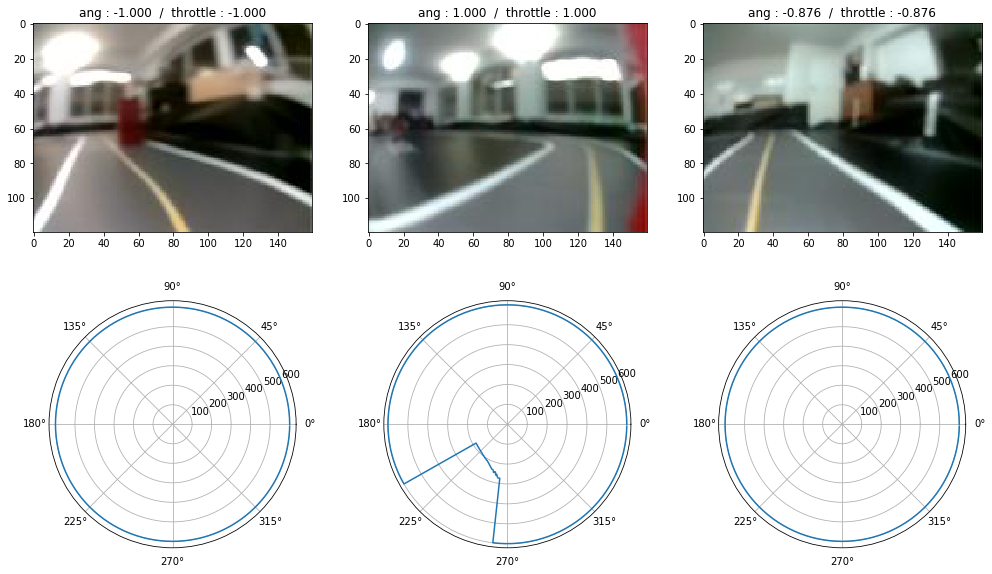

In [16]:
random_values = tubes_df.sample(3).reset_index().iterrows()

fig = plt.figure(figsize=(17,10))

for n, sample in random_values:
    
    lidar_360 = sample['lidar/clipped_distances']
    random_image_path = sample["images_path"]
    angle = sample["angles"]
    throttle = sample["throttles"]
    image = mpimg.imread(random_image_path)
    
    plt.subplot(2, 3, n+1)
    plt.imshow(image)
    plt.title("ang : {0:.3f}  /  throttle : {0:.3f}".format(angle, throttle))
    
    plt.subplot(2, 3, n+4, projection='polar')
    plt.plot(np.deg2rad(range(360)), lidar_360)

#### **- Display some sample distribution**

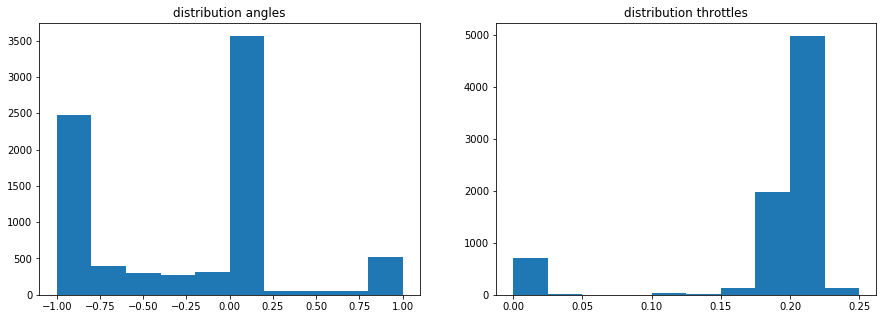

In [17]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(tubes_df.angles)
axs[0].set_title('distribution angles')
axs[1].hist(tubes_df.throttles)
axs[1].set_title('distribution throttles')

plt.show()

#### **- Display some gif**

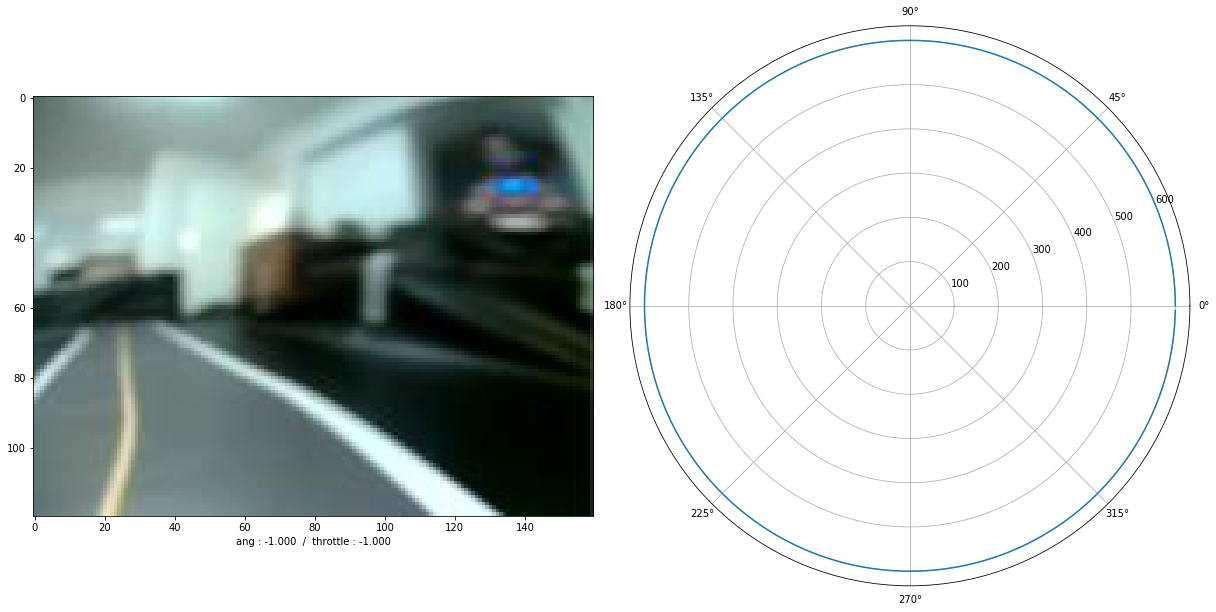

In [18]:
num_tubes = 300
offset_tubes = 250

rows = tubes_df[offset_tubes:(offset_tubes+num_tubes)].iterrows()

# Create figure
fig = plt.figure(figsize=(17,10))
fig.set_tight_layout(True)

# Axes (img, lidar)
ax_im = fig.add_subplot(1, 2, 1)
ax_lid = fig.add_subplot(1, 2, 2, projection='polar')

def update(df_row):
    index, row = df_row
    
    # Plot
    ax_im.imshow(mpimg.imread(row["images_path"]))
    ax_im.set_xlabel("ang : {0:.3f}  /  throttle : {0:.3f}".format(row["angles"], row["throttles"]))
    ax_lid.clear()
    ax_lid.plot(np.deg2rad(range(360)), row['lidar/clipped_distances'])
    return ax_im, ax_lid

anim = FuncAnimation(fig, update, frames=rows, interval=50)

In [19]:
#anim.save('lidar.gif', dpi=80, writer='imagemagick')
#display(HTML(anim.to_jshtml()))

# Preprocessing Images

**Images will be :**
- Loaded
    - Read images
    - Decode jpeg images into uint8 tensor
- Cropped
    - Crop images on the lower part
- Augmented
    - Brightness : Adjust the brightness of images by a random factor.
    - Saturation : Adjust the saturation of images by a random factor (must be RGB images)
    - Contrast : Adjust the contrast of images by a random factor.
    - Jpeg quality : Randomly changes jpeg encoding quality for inducing jpeg noise
- Normalized
    - Image are converted into Float32 between 0 and 1
- Edged
    - Convert tensor uint8 type into float32 type
    - Convert rgb images to grayscale
    - Reshape into [1, 80, 160, 1] tensor
    - Apply sobel filter (see https://en.wikipedia.org/wiki/Sobel_operator)
    - Reshape into [80, 160, 2] tensor
    - Select image gradient up to 0.3
    - Binarize images by setting elements to 0 or 1

##### **- Display some examples before and after preprocessing**

In [20]:
crop_fn = T.generate_crop_fn(left_margin=0, width=160, height_margin=40, height=80)
clip_max = 600

def lidar_preprocess(lidar):
    lidar = tf.clip_by_value(lidar, clip_value_min = 0, clip_value_max=clip_max)
    lidar = 1 - lidar/clip_max
    return lidar

def load_augmentation_preprocess(image_path):
    tf_image = T.read_image(image_path)
    tf_image = T.normalize(tf_image)
    tf_image = crop_fn(tf_image)
    tf_image = T.data_augmentation(tf_image)
    tf_image = T.edges(tf_image)
    return tf_image

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


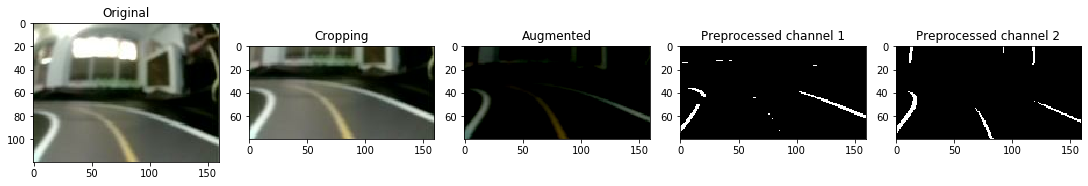

In [21]:
random_image_path_lidar_output = tubes_df.sample()[["images_path","lidar/output"]].values[0]
random_image_path = random_image_path_lidar_output[0]

tf_image_original   = T.read_image(random_image_path)
tf_image_cropped    = crop_fn(tf_image_original)
tf_image_augmented  = T.data_augmentation(tf_image_cropped)
tf_image_normalized = T.normalize(tf_image_augmented)
tf_image_edged      = T.edges(tf_image_normalized)

fig, axs = plt.subplots(1, 5, figsize=(15,15), constrained_layout=True)
axs[0].set_title("Original")
axs[0].imshow(tf_image_original)
axs[1].set_title("Cropping")
axs[1].imshow(tf_image_cropped)
axs[2].set_title("Augmented")
axs[2].imshow(tf_image_augmented)
axs[3].set_title("Preprocessed channel 1")
axs[3].imshow(tf_image_edged[:,:,0],cmap='gray')
axs[4].set_title("Preprocessed channel 2")
axs[4].imshow(tf_image_edged[:,:,1],cmap='gray')
plt.show()

# Build a dataset of images

#### **- Split data into test/train datasets**

Note : We only use angle as label

In [22]:
images_path_and_lidar_outputs = [x for x in zip(tubes_df["images_path"].tolist(), tubes_df["lidar/output"].tolist())]
metas_angle = tubes_df["angles"].tolist()
metas_throttle = tubes_df["throttles"].tolist()

In [23]:
train_images_path_lidar_outputs, test_images_path_lidar_outputs, train_metas, test_metas = train_test_split(images_path_and_lidar_outputs, metas_angle, test_size=test_size)
print('Train set :', len(train_images_path_lidar_outputs), 'images')
print('Test set :', len(test_images_path_lidar_outputs), 'images')

Train set : 5602 images
Test set : 2402 images


#### **- Create tensor for train and test datasets**

In [24]:
def input_fn(filepath, lidar, label, BATCH_SIZE = 32, SHUFFLE_SIZE = 200, NUM_EPOCHS = 50, NUM_REPEAT=200):
    ds_x = tf.data.Dataset.from_tensor_slices(filepath)
    ds_x = ds_x.map(load_augmentation_preprocess)
    ds_l = tf.data.Dataset.from_tensor_slices(lidar)
    ds_l = ds_l.map(lidar_preprocess)
    ds_y = tf.data.Dataset.from_tensor_slices(label)
    ds_xl_y = tf.data.Dataset.zip(((ds_x, ds_l), ds_y)).shuffle(SHUFFLE_SIZE).repeat(NUM_REPEAT).batch(BATCH_SIZE).prefetch(1)
    
    return ds_xl_y

In [25]:
train_images_path = [x[0] for x in train_images_path_lidar_outputs]
train_lidar_outputs = [x[1] for x in train_images_path_lidar_outputs]
test_images_path = [x[0] for x in test_images_path_lidar_outputs]
test_lidar_outputs = [x[1] for x in test_images_path_lidar_outputs]

In [26]:
print(len(train_lidar_outputs)==len(train_images_path))
print(len(test_lidar_outputs)==len(test_images_path))

True
True


In [27]:
ds_train = input_fn(train_images_path, train_lidar_outputs, train_metas)
ds_test = input_fn(test_images_path, train_lidar_outputs, test_metas)

In [28]:
ds_train.output_shapes

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


((TensorShape([Dimension(None), Dimension(80), Dimension(160), Dimension(2)]),
  TensorShape([Dimension(None), Dimension(360)])),
 TensorShape([Dimension(None)]))

# Build Model

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input

In [30]:
main_input = Input(shape = ds_train.output_shapes[0][0][1:4], name='main_input')
lidar_input = Input(shape = (ds_train.output_shapes[0][1][1],), name='lidar_input')

In [31]:
##########################
## convolutional layers ##
##########################

x = tf.keras.layers.Conv2D(filters = 16,
                           kernel_size = (5,5), 
                           activation='relu', 
                           kernel_regularizer=l1_l2(l1=0.1, l2=0.01))(main_input)
x = tf.keras.layers.MaxPooling2D((3,3))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(filters = 32,
                           kernel_size = (3,3), 
                           activation='relu', 
                           kernel_regularizer=l1_l2(l1=0.1, l2=0.01))(x)
x = tf.keras.layers.MaxPooling2D((3,3))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3,3), 
                           activation='relu', 
                           kernel_regularizer=l1_l2(l1=0.1, l2=0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
# flatten
x = tf.keras.layers.Flatten()(x)
# add lidar inputs

y = tf.expand_dims(lidar_input,-1)
y = tf.keras.layers.Conv1D(filters=32, kernel_size=18, activation='relu')(y)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dense(360, activation ='relu')(lidar_input)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(180, activation ='relu')(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dropout(0.4)(y)
y = tf.keras.layers.Dense(90, activation ='relu')(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dropout(0.4)(y)
y = tf.keras.layers.Dense(45, activation ='relu')(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dropout(0.4)(y)
y = tf.keras.layers.Dense(36, activation ='relu')(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dropout(0.4)(y)
y = tf.keras.layers.Dense(10, activation ='relu')(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dropout(0.4)(y)
x = tf.keras.layers.concatenate([x, y])

##################
## dense layers ##
##################

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(1, activation='linear')(x)

In [32]:
model = Model(inputs=[main_input, lidar_input], outputs = output)

In [33]:
#decay=learning_rate//batch_size
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lidar_input (InputLayer)        [(None, 360)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 360)          129960      lidar_input[0][0]                
__________________________________________________________________________________________________
dropout (Dropout)               (None, 360)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 180)          64980       dropout[0][0]                    
______________________________________________________________________________________________

**- How to choose and interpret loss :**

Mean Absolute Error (MAE) is the absolute value of the substraction of predicted from actual value


In [34]:
mlflow.set_experiment("drive_auto_image_and_lidar_Xebicon_circuit")

with mlflow.start_run():
    mlflow.log_params({
        "images": str(tubes_folders),
        "nb_images": len(train_images_path),
        "epochs": n_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    })
    mlflow.tensorflow.autolog()
    history = model.fit(x=ds_train,
                    steps_per_epoch=len(train_metas)//batch_size,
                    epochs=n_epochs,
                    verbose=1,
                    validation_data=ds_test,
                    validation_steps=len(test_metas)//batch_size)

INFO: 'drive_auto_image_and_lidar_Xebicon_circuit' does not exist. Creating a new experiment
Epoch 1/50
350/350 [==============================] - 149s 426ms/step - loss: 86.1705 - val_loss: 63.7501
Epoch 2/50
350/350 [==============================] - 147s 419ms/step - loss: 46.7736 - val_loss: 31.7747
Epoch 3/50
350/350 [==============================] - 131s 375ms/step - loss: 22.4613 - val_loss: 14.9997
Epoch 4/50
350/350 [==============================] - 133s 381ms/step - loss: 11.2388 - val_loss: 8.1265
Epoch 5/50
350/350 [==============================] - 134s 382ms/step - loss: 6.3382 - val_loss: 4.7358
Epoch 6/50
350/350 [==============================] - 149s 427ms/step - loss: 3.7374 - val_loss: 2.7783
Epoch 7/50
350/350 [==============================] - 138s 395ms/step - loss: 2.2346 - val_loss: 1.5897
Epoch 8/50
350/350 [==============================] - 143s 408ms/step - loss: 1.3819 - val_loss: 1.0048
Epoch 9/50
350/350 [==============================] - 158s 453ms/ste

# Plot loss

In [35]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=['loss','val_loss']
    hist_df.index = np.arange(1, len(hist_df)+1)
    fig = plt.figure(figsize=(10,5))
    plt.plot(hist_df.val_loss, lw=3, label='Validation Loss')
    plt.plot(hist_df.loss, lw=3, label='Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(loc=0)
    plt.ylim(0,20)
    
    plt.show()

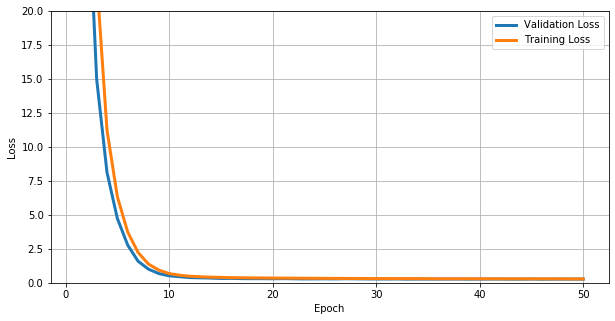

In [36]:
plot_results(history)

# Evaluation

**- steps:** Total number of steps (batches of samples) before declaring the prediction round finished. Ignored with the default value of None. If x is a tf.data dataset or a dataset iterator, and steps is None, predict will run until the input dataset is exhausted.

In [37]:
train_angles = model.predict(ds_test, steps=len(test_metas)//batch_size)

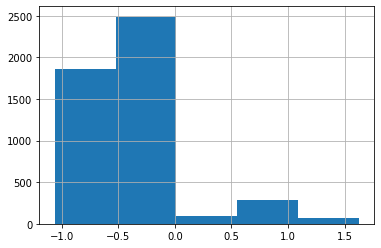

In [38]:
df = pd.DataFrame(train_angles, columns = ['angles'])
df.angles.hist(bins=5)

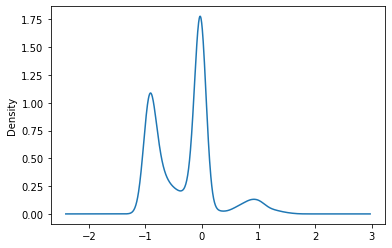

In [39]:
df.angles.plot.kde()